## <u>Buffer Overflow and Vulnerability Analysis Using CNN and Binary Visualization</u> 
#### By: James Shima, CSCI 575 Final Project

### Problem Statement
Vulnerabilities in code bases can greatly impact confidentiality, integrity and availability for all businesses and consumers.  This can lead to millions of dollars in damages, leaked consumer data and much more.  Bad actors that may develop these weaknesses or discover them many times go undiscovered for long periods of time making the damages even worse.  To help prevent this, AI/ML has been researched as a potential tool to detect bad code to prevent such damages before production, or to the advantage of attackers to find new vulnerabilities. National Institute of Standards and Technology (NIST), has provided a large testing suite call <a href=https://samate.nist.gov/SARD/test-suites/112>Juliet (v1.3)</a> of Common Weakness Enumerations (CWEs) in C/C++ that has acted as a common benchmark for vulnerability detection [1].  However most research in this field has only been done on the hashes of such code files.  The problem with this is hashes generalize data to only 256 bits for SHA256 for example, which may not be as indicative of the vulnerability at hand.  That is why in this project I look into a different approach using x86 assembly and object files. 

### Solution
My solution uses a forked version of the Juliet 1.3 dataset called <a href=https://gitlab.com/dlr-dw/romeo>ROMEO</a> [2].  This dataset instead of having the C file equivalents of the vulnerabilities has compiled x86 versions.  Using these object files, I created a simple binary to image converter in python that losslessly converts the bytes of said object files into (256x256) grayscale images.  This way, no data is lost during analysis like it would be when using a hash function instead.  I then use these images in a Convolutional Neural Network (`CNN`), commonly used for image detection, to classify some of the common vulnerabilities defined by NIST in this assembled dataset.  

## Demo/How it was Built is Shown Below...

## Image Conversion Example `img.py` (see `requirements.txt` for self replication)
Below is an example of the code I created for turning obj files in `testcases` i.e. `ROMEO` into the grayscale images used for training this model `images2`

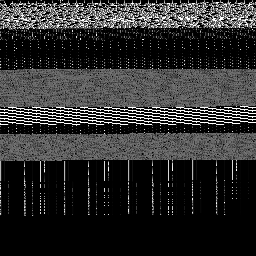

In [26]:
from PIL import Image

def makeIMG(imgpath):
    
    data = [0]*65536 # 256 by 256 pixel image 
    with open(imgpath,"rb")as f:
        d = f.read()
        for i,v in enumerate(d):
            try:
                data[i]= v
            except:
                print("ind out of bounds,",imgpath,i,len(d))
                files_missed+=1
                return
    image = Image.frombytes('L',(256,256), bytes(data), 'raw')
    
    display(image)

makeIMG("testcases/Free_Memory_Not_on_Heap/CWE590_Free_Memory_Not_on_Heap__delete_array_char_alloca_74a.o")


## CNN Training (see `README.md` for requirements to replicate results)

For this expirement, I used a subset of the original `ROMEO/Juliet` dataset as there is just too much data and so little time to train on all of it (over `60,000` images I created and 90 classes) on my old laptop without access to a `HPC`.  Thus, my dataset was trained on the dir `images2` rather than `images` (the full dataset created by `img.py`) which only includes memory based vulnerbilities rather than all the Juilet standards for CWEs.  This way I can still train in a reasonable amount of time and keep the network focused on more specific vulnerbilities. In the future or with access to a `HPC` I could contiune this research futher with the entire `ROMEO` dataset in `images` or create seperate networks [3].

In [79]:
from keras.utils import image_dataset_from_directory
from keras.models import Sequential
from keras.layers import Dense, Flatten,Conv2D,MaxPooling2D,BatchNormalization,Activation,Dropout,Softmax
from keras.optimizers import Adam
from keras.callbacks import LearningRateScheduler
from tensorflow import math as tfm
from matplotlib import pyplot as plt

img_height = 256
img_width = 256
batch_size = 8

In [80]:
data = "images2"
train_ds = image_dataset_from_directory(data,validation_split=0.2,subset="training",seed=123,image_size=(img_height, img_width),batch_size=batch_size,color_mode="grayscale")
validation_ds = image_dataset_from_directory(data,validation_split=0.2,subset="validation",seed=123,image_size=(img_height, img_width),batch_size=batch_size,color_mode="grayscale")


Found 24108 files belonging to 3 classes.
Using 19287 files for training.
Found 24108 files belonging to 3 classes.
Using 4821 files for validation.


In [82]:
CNN = Sequential()
CNN.add(Conv2D(16, (3,3), padding='same', input_shape=(img_height,img_width,1)))
CNN.add(BatchNormalization())
CNN.add(Activation('relu'))
CNN.add(MaxPooling2D((2,2)))
CNN.add(Conv2D(32, (3,3), padding='same'))
CNN.add(BatchNormalization())
CNN.add(Activation('relu'))
CNN.add(MaxPooling2D((2,2)))
CNN.add(Conv2D(32, (3,3), padding='same'))
CNN.add(BatchNormalization())
CNN.add(Activation('relu'))
CNN.add(MaxPooling2D((2,2)))
CNN.add(Conv2D(64, (3,3), padding='same'))
CNN.add(BatchNormalization())
CNN.add(Activation('relu'))
CNN.add(MaxPooling2D((2,2)))
CNN.add(Conv2D(32, (3,3), padding='same'))
CNN.add(BatchNormalization())
CNN.add(Activation('relu'))
CNN.add(MaxPooling2D((2,2)))
CNN.add(Conv2D(32, (3,3), padding='same'))
CNN.add(BatchNormalization())
CNN.add(Activation('relu'))
CNN.add(MaxPooling2D((2,2)))
CNN.add(Flatten())
CNN.add(Dense(64, activation='relu'))
CNN.add(Dropout(0.5))
CNN.add(Dense(len(train_ds.class_names), name="outputs"))
CNN.add(Softmax())


CNN.compile(loss="sparse_categorical_crossentropy", optimizer=Adam(learning_rate = 1e-3), metrics=['accuracy'])

CNN.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_42 (Conv2D)          (None, 256, 256, 16)      160       
                                                                 
 batch_normalization_37 (Bat  (None, 256, 256, 16)     64        
 chNormalization)                                                
                                                                 
 activation_42 (Activation)  (None, 256, 256, 16)      0         
                                                                 
 max_pooling2d_42 (MaxPoolin  (None, 128, 128, 16)     0         
 g2D)                                                            
                                                                 
 conv2d_43 (Conv2D)          (None, 128, 128, 32)      4640      
                                                                 
 batch_normalization_38 (Bat  (None, 128, 128, 32)    

In [83]:
history = CNN.fit(train_ds, epochs=10, batch_size=batch_size, validation_data=validation_ds)

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

print("Final acc:",val_acc[-1])
print("Final loss:",val_loss[-1])

CNN.save_weights("weights")

Epoch 1/10
2411/2411 [==============================] - 738s 306ms/step - loss: 1.0218 - accuracy: 0.4638 - val_loss: 0.9571 - val_accuracy: 0.5125
Epoch 2/10
2411/2411 [==============================] - 782s 324ms/step - loss: 0.9052 - accuracy: 0.5357 - val_loss: 0.8757 - val_accuracy: 0.5482
Epoch 3/10
2411/2411 [==============================] - 784s 325ms/step - loss: 0.7930 - accuracy: 0.6097 - val_loss: 0.6926 - val_accuracy: 0.6459
Epoch 4/10
2411/2411 [==============================] - 747s 310ms/step - loss: 0.7139 - accuracy: 0.6667 - val_loss: 0.6013 - val_accuracy: 0.7254
Epoch 5/10
2411/2411 [==============================] - 740s 307ms/step - loss: 0.6439 - accuracy: 0.7162 - val_loss: 0.5252 - val_accuracy: 0.7783
Epoch 6/10
2411/2411 [==============================] - 741s 307ms/step - loss: 0.5822 - accuracy: 0.7492 - val_loss: 0.4814 - val_accuracy: 0.7996
Epoch 7/10
2411/2411 [==============================] - 742s 308ms/step - loss: 0.5031 - accuracy: 0.7870 - val_

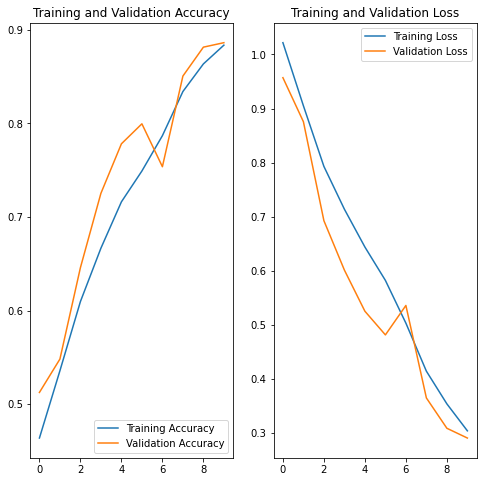

In [84]:
epochs_range = range(10)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Assumptions, Constraints & Implications 

As shown, this model was fairly decent at classifing different types of buffer overflows and memory vulnerbilities from the given data set with `80-90%` accuracy against the validation data.  However I was constraint to using my laptop which took many hours to train only 10 epochs with the large amount of images for just 3 memory based classes!  If I had access to a `HPC` I could test my model way more and fine tune it for even higher accuracy scores.  I also had to cut down on the number of classes from `ROVER` and its `images` from 90 CWE classes to just 3 classes in `images2`.  This way I could acctually see results before this report is due.  What this overall impiles is that image classification and binary visualization can be a useful ML method for detecting CWEs in application code. Potentially even more so than using hashes.  However, futher research should be done with higher power computing devices and more model tunning.

## How it was Built
See above work!

## Summary
In conclusion, this `CNN` works very well for the little amount of epochs and model tweaking done.  With even more time to fine tune this model and more time to train on a `HPC`, I believe even higher accuracy can be achevived here.  In additon, more classes from `ROMEO` in `images` can be added given enough time and computing reasources for future work.  Lastly, another class can be added which was not a part of `Juliet1.3` for safe code that can make this model deployable in analyizing compiled C/C++ binaries/functions as either safe of vulnerbile to some CWEs.  That in itself is already a common antimalware application used but this model could show even more promises and futher applications across cyber security. 

## Works Cited
[1] "Test Suites: 112," NIST Software Assurance Reference Dataset (SARD). [Online]. Available: https://samate.nist.gov/SARD/test-suites/112. [Accessed: 08-May-2024].

[2] C.-A. Brust, T. Sonnekalb, B. Gruner, "ROMEO: A binary vulnerability detection dataset for exploring Juliet through the lens of assembly language," Computers & Security, vol. 128, p. 103165, May 2023, doi: 10.1016/j.cose.2023.103165.

[3] "Image classification," TensorFlow Tutorials. [Online]. Available: https://www.tensorflow.org/tutorials/images/classification. [Accessed: 08-May-2024].